### R2U-Net

Task: Implement R2U-Net model from the paper https://arxiv.org/abs/1802.06955 <br/>

Metrics for evaluation: Accuracy, sensitivity, specificity, f1-score, Dice-coefficient, Jaccard Similarity, AUC and ROC curve. <br/>

$$Acc = \frac{TP+TN}{TP+TN+FP+FN}$$
$$SE = \frac{TP}{TP+FN}$$
$$SP = \frac{TN}{TN+FP}$$
$$DC = \frac{|GT \cap SR|}{|GT| + |SR|}$$
$$JS = \frac{|GT \cap SR|}{|GT \cup SR|}$$

In [1]:
!pip install scipy==1.1.0

In [2]:
# Imports
import os
from os.path import join as pjoin
import collections
import json
import torch
import imageio
import numpy as np
import scipy.misc as m
import scipy.io as io
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import glob
import torch.nn as nn
import torchvision

from PIL import Image
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms
from torchvision.datasets import Cityscapes
import torch.nn as nn

In [3]:
# cityscapes Dataloader: https://github.com/Tramac/awesome-semantic-segmentation-pytorch/blob/master/core/data/dataloader/cityscapes.py
# https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/loader/cityscapes_loader.py

In [4]:
#!wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=s8awdesh&password=OfficialNLP*&submit=Login' https://www.cityscapes-dataset.com/login/

# !wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3 # => leftImg8bit
# !wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1 #=> gtFine

# !unzip gtFine_trainvaltest.zip
# !unzip leftImg8bit_trainvaltest.zip

In [5]:
def recursive_glob(rootdir=".", suffix=""):
  """Performs recursive glob with given suffix and rootdir
      :param rootdir is the root directory
      :param suffix is the suffix to be searched
  """
  return [
          os.path.join(looproot, filename)
          for looproot, _, filenames in os.walk(rootdir)
          for filename in filenames
          if filename.endswith(suffix)
    ]

class cityscapesLoader(data.Dataset):
  """
  cityscapesLoader
  https://www.cityscapes-dataset.com
  Data is derived from CityScapes, and can be downloaded from here:
  https://www.cityscapes-dataset.com/downloads/
  Many Thanks to @fvisin for the loader repo:
  https://github.com/fvisin/dataset_loaders/blob/master/dataset_loaders/images/cityscapes.py
  """
  colors = [  # [  0,   0,   0], [128, 64, 128], [244, 35, 232], [70, 70, 70],
        [102, 102, 156], [190, 153, 153], [153, 153, 153], [250, 170, 30],
        [220, 220, 0], [107, 142, 35], [152, 251, 152], [0, 130, 180],
        [220, 20, 60], [255, 0, 0], [0, 0, 142], [0, 0, 70],
        [0, 60, 100], [0, 80, 100], [0, 0, 230], [119, 11, 32],
        ]
  
  label_colours = dict(zip(range(19), colors))
  
  mean_rgb = {
        "pascal": [103.939, 116.779, 123.68],
        "cityscapes": [0.0, 0.0, 0.0],
  }  # pascal mean for PSPNet and ICNet pre-trained model
  
  def __init__(
      self,
      root,
      split="train",
      is_transform=False,
      #img_size=(512, 1024),
      img_size=(1024, 2048),
      augmentations=None,
      img_norm=True,
      version="cityscapes",
      test_mode=False,
      ):
    """__init__
    :param root:
    :param split:
    :param is_transform:
    :param img_size:
    :param augmentations
    """
    self.root = root
    self.split = split
    self.is_transform = is_transform
    self.augmentations = augmentations
    self.img_norm = img_norm
    self.n_classes = 19
    self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
    self.mean = np.array(self.mean_rgb[version])
    self.files = {}
    
    self.images_base = os.path.join(self.root, "leftImg8bit", self.split)
    self.annotations_base = os.path.join(self.root, "gtFine", self.split)
    self.files[split] = recursive_glob(rootdir=self.images_base, suffix=".png")
    
    self.void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
    self.valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25,
                          26, 27, 28, 31, 32, 33,]
    
    self.class_names = ["unlabelled", "road", "sidewalk", "building",
                            "wall", "fence", "pole", "traffic_light",
                            "traffic_sign", "vegetation", "terrain", "sky",
                            "person", "rider", "car", "truck", "bus",
                            "train", "motorcycle", "bicycle"]
    
    self.ignore_index = 250
    self.class_map = dict(zip(self.valid_classes, range(19)))
    
    if not self.files[split]:
      raise Exception("No files for split=[%s] found in %s" % (split, self.images_base))
    
    print("Found %d %s images" % (len(self.files[split]), split))

  def __len__(self):
    return len(self.files[self.split])+0
      
  def __getitem__(self, index):
    """__getitem__
    :param index:
    """
    img_path = self.files[self.split][index].rstrip()
    lbl_path = os.path.join(
        self.annotations_base,
        img_path.split(os.sep)[-2],
        os.path.basename(img_path)[:-15] + "gtFine_labelIds.png",
    )
    
    img = m.imread(img_path)
    img = np.array(img, dtype=np.uint8)
    
    lbl = m.imread(lbl_path)
    lbl = self.encode_segmap(np.array(lbl, dtype=np.uint8))
    
    if self.augmentations is not None:
      img, lbl = self.augmentations(img, lbl)
    
    if self.is_transform:
        img, lbl = self.transform(img, lbl)

    return img, lbl
    
  def transform(self, img, lbl):
    """transform
    :param img:
    :param lbl:
    """
    img = m.imresize(img, (self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
    img = img[:, :, ::-1]  # RGB -> BGR
    img = img.astype(np.float64)
    img -= self.mean
    if self.img_norm:
      # Resize scales images from 0 to 255, thus we need
      # to divide by 255.0
      img = img.astype(float) / 255.0
    # NHWC -> NCHW
    img = img.transpose(2, 0, 1)
    
    classes = np.unique(lbl)
    lbl = lbl.astype(float)
    lbl = m.imresize(lbl, (self.img_size[0], self.img_size[1]), "nearest", mode="F")
    lbl = lbl.astype(int)
    
    if not np.all(classes == np.unique(lbl)):
      print("WARN: resizing labels yielded fewer classes")
    
    if not np.all(np.unique(lbl[lbl != self.ignore_index]) < self.n_classes):
      print("after det", classes, np.unique(lbl))
      raise ValueError("Segmentation map contained invalid class values")

    img = torch.from_numpy(img).float()
    lbl = torch.from_numpy(lbl).long()
    return img, lbl
      
  def decode_segmap(self, temp):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, self.n_classes):
      r[temp == l] = self.label_colours[l][0]
      g[temp == l] = self.label_colours[l][1]
      b[temp == l] = self.label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb
    
  def encode_segmap(self, mask):
    # Put all void classes to zero
    for _voidc in self.void_classes:
      mask[mask == _voidc] = self.ignore_index
    for _validc in self.valid_classes:
      mask[mask == _validc] = self.class_map[_validc]
    return mask

In [6]:
local_path = "./"
dst = cityscapesLoader(root=local_path)
epochs = 2
bs = 1

Found 2975 train images


In [7]:
trainloader = data.DataLoader(dst, batch_size=bs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.


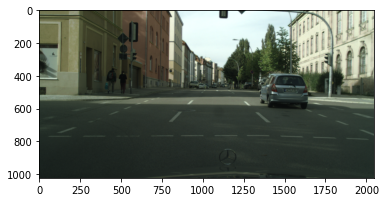

torch.Size([1, 1024, 2048, 3])
torch.Size([1, 3, 1024, 2048])


In [8]:
## Just added this cell for visualization of 3 images
def imshow(inp, title=None):
  """Imshow for Tensor."""
  #inp = inp.numpy().transpose((1, 2, 0))
  inp = inp.numpy()
  #mean = np.array([0.5, 0.5, 0.5])
  #std = np.array([0.5, 0.5, 0.5])
  #inp = std * inp + mean
  #inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
      plt.title(title)

it = iter(trainloader)

images, labels = next(it)
out = torchvision.utils.make_grid(images)
imshow(out)
plt.show()

print(images.shape)
#i2 = np.moveaxis(images.numpy(), -1, 1).toTensor()
i2 = images.permute(0, 3, 1, 2)
print(i2.shape)

In [9]:
# Define normal convolution block
def conv_block(in_c, out_c):
  conv = nn.Sequential(
      nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1, bias=True),
      nn.BatchNorm2d(out_c),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1, bias=True),
      nn.BatchNorm2d(out_c),
      nn.ReLU(inplace=True)
      )
  return conv

# Define up convolution block
def up_conv(in_c, out_c):
  upconv = nn.Sequential(
      nn.Upsample(scale_factor=2),
      nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1, bias=True),
      nn.BatchNorm2d(out_c),
      nn.ReLU(inplace=True)
      )
  return upconv

# Define recurrent block
def rec_block(out_c, t=2):
  rec_conv = nn.Sequential(
      nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1, bias=True),
      nn.BatchNorm2d(out_c),
      nn.ReLU(inplace=True)
      )
  return rec_conv

# Define recurrent residual block
class rr_block(nn.Module):
  def __init__(self, in_c, out_c, t=2):
    super(rr_block, self).__init__()
    
    self.rcnn = nn.Sequential(
        rec_block(out_c, t=t),
        rec_block(out_c, t=t)
        )
    self.conv = nn.Conv2d(in_c, out_c, kernel_size=1, stride=1, padding=0)
  
  def forward(self, image):
    x1 = self.conv(image)
    x2 = self.rcnn(x1)
    out = x1+x2
    return out

class R2UNet(nn.Module):
  #img_ch=3, output_ch=1, t=2
  def __init__(self):
    super(R2UNet, self).__init__()

    n1 = 64
    filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

    self.Maxpool0 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.Upsample = nn.Upsample(scale_factor=2)

    self.RR_block1 = rr_block(3, filters[0], t=2)
    self.RR_block2 = rr_block(filters[0], filters[1], t=2)
    self.RR_block3 = rr_block(filters[1], filters[2], t=2)
    self.RR_block4 = rr_block(filters[2], filters[3], t=2)
    self.RR_block5 = rr_block(filters[3], filters[4], t=2)
    
    self.Up5 = up_conv(filters[4], filters[3])
    self.Up_rr_block5 = rr_block(filters[4], filters[3], t=2)

    self.Up4 = up_conv(filters[3], filters[2])
    self.Up_rr_block4 = rr_block(filters[3], filters[2], t=2)
    
    self.Up3 = up_conv(filters[2], filters[1])
    self.Up_rr_block3 = rr_block(filters[2], filters[1], t=2)
    
    self.Up2 = up_conv(filters[1], filters[0])
    self.Up_rr_block2 = rr_block(filters[1], filters[0], t=2)
    
    self.Conv = nn.Conv2d(filters[0], 1, kernel_size=1, stride=1, padding=0)

  def forward(self, image): 
    x1 = self.RR_block1(image)
    
    x2 = self.Maxpool0(x1)
    x2 = self.RR_block2(x2)

    x3 = self.Maxpool1(x2)
    x3 = self.RR_block3(x3)

    x4 = self.Maxpool2(x3)
    x4 = self.RR_block4(x4)

    x5 = self.Maxpool3(x4)
    x5 = self.RR_block5(x5)

    y5 = self.Up5(x5)
    y5 = torch.cat((x4, y5), dim=1)
    y5 = self.Up_rr_block5(y5)

    y4 = self.Up4(y5)
    y4 = torch.cat((x3, y4), dim=1)
    y4 = self.Up_rr_block4(y4)

    y3 = self.Up3(y4)
    y3 = torch.cat((x2, y3), dim=1)
    y3 = self.Up_rr_block3(y3)

    y2 = self.Up2(y3)
    y2 = torch.cat((x1, y2), dim=1)
    y2 = self.Up_rr_block2(y2)

    out = self.Conv(y2)
    return out

In [10]:
model = R2UNet()
#print(model)

In [11]:
# loss function
loss_f = nn.CrossEntropyLoss()

# optimizer variable
# opt = torch.optim.SGD(model.parameters(), weight_decay=5*1e-4, lr = 0.0001, momentum=0.9)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

def train(dataset, data_loader, model, criterion, optimizer, epochs):
  """
  training function that trains for one epoch
  :param dataset: dataset class (SIIMDataset)
  :param data_loader: torch dataset loader
  :param model: model
  :param criterion: loss function
  :param optimizer: adam, sgd, etc.
  """
  if torch.cuda.is_available():
    criterion = criterion.cuda()
  
  # put the model in train mode
  model.train()
  # calculate number of batches
  num_batches = int(len(dataset)/data_loader.batch_size)
  train_loss = []
  model_weights = []
  
  for epoch in range (epochs):
    #tk0 = tqdm(data_loader, total=num_batches)
    with tqdm(data_loader, unit="batch") as tk0:
      for inputs, targets in tk0:
        tk0.set_description(f"Epoch {epoch+1}")
        #rorder image channels to [batch, channel, height, width] format
        inputs = inputs.permute(0, 3, 1, 2)
        
        # fetch input images and masks from dataset batch
        # move images and masks to cpu/gpu device
        inputs = inputs.to(DEVICE, dtype=torch.float)
        targets = targets.to(DEVICE, dtype=torch.long)
        # zero grad the optimizer
        optimizer.zero_grad()
        
        # forward step of model
        outputs = model(inputs)
        # calculate loss
        loss = criterion(outputs, targets)

        #backward loss
        loss.backward()
        # step the optimizer
        optimizer.step()
        tk0.set_postfix(loss=loss.item())
      model_weights.append(model.state_dict())
      train_loss.append(loss.item())
  return train_loss, model_weights

In [ ]:
criterion = loss_f
history = train(dst, trainloader, model, criterion, opt, epochs)

In [ ]:
plt.plot(history[0])

### References: <br/>
https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/loader/cityscapes_loader.py <br/>
https://github.com/LeeJunHyun/Image_Segmentation/blob/master/network.py <br/>
https://github.com/bigmb/Unet-Segmentation-Pytorch-Nest-of-Unets